## 使用模型

In [ ]:
import torch
import sys
sys.path.append("../model")
# from basicamt import BasicAMT_all
model = torch.load("basicamt_model.pth", map_location=torch.device('cpu'))
s_per_frame = 256 / 22050

# 二值化
import matplotlib.pyplot as plt
from utils.midiarray import output2midi, midi2numpy

def create_note(audio_name, onset, note, s_per_frame, onset_threshold=0.145, note_threshold=0.4):
    mid = output2midi(onset, note, s_per_frame, onset_threshold, note_threshold)
    mid.save(f"../test/{audio_name}.mid")
    print(f"saved midi to '../test/{audio_name}.mid'")

    plt.figure(figsize=(12, 5))
    plt.title('Note')
    plt.imshow(midi2numpy(mid, s_per_frame), aspect='auto', origin='lower', cmap='gray')
    plt.show()

    return mid

downsampled to 22050Hz


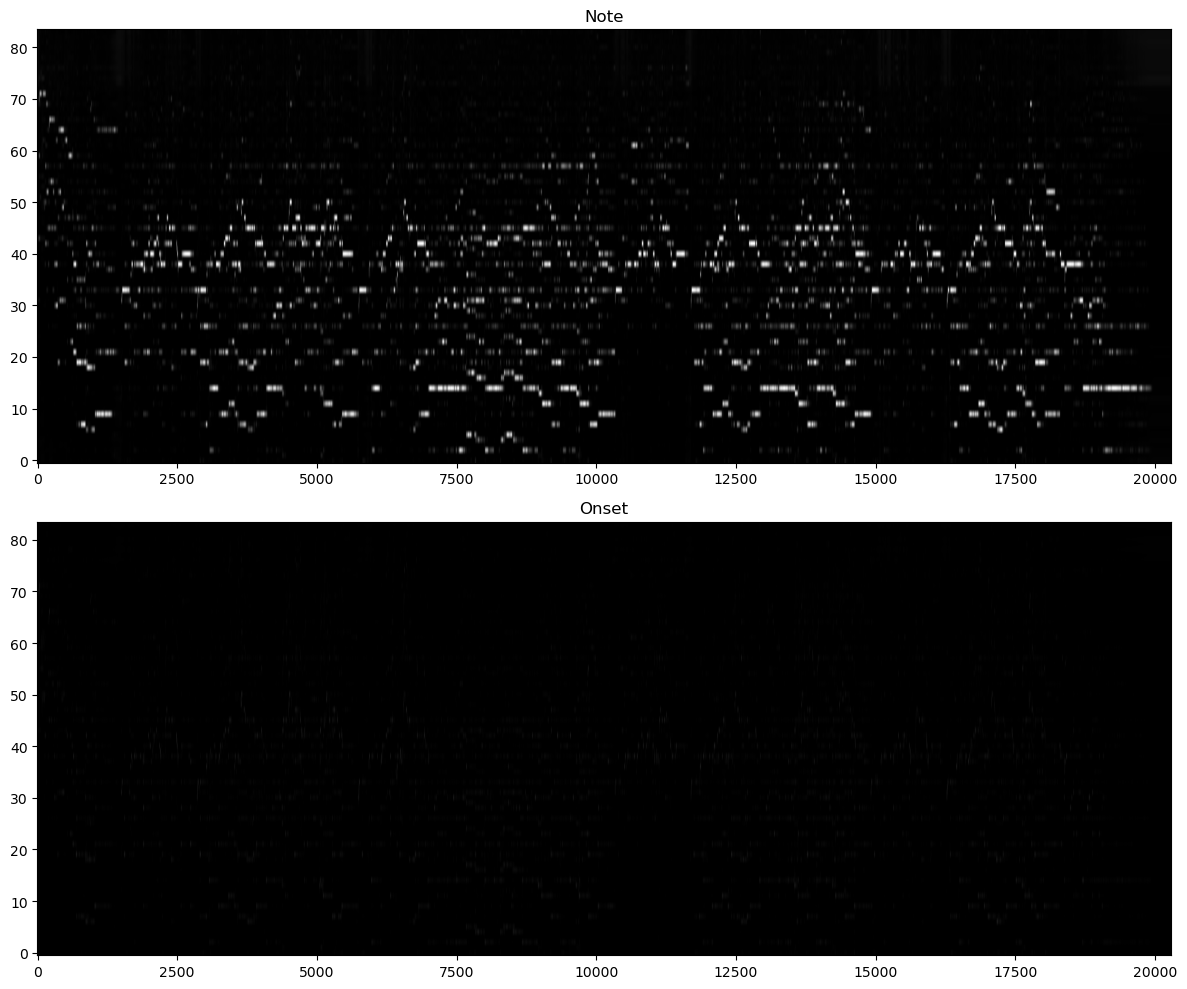

saved midi to '../test/origin_加藤達也-Always in my heart.mid'


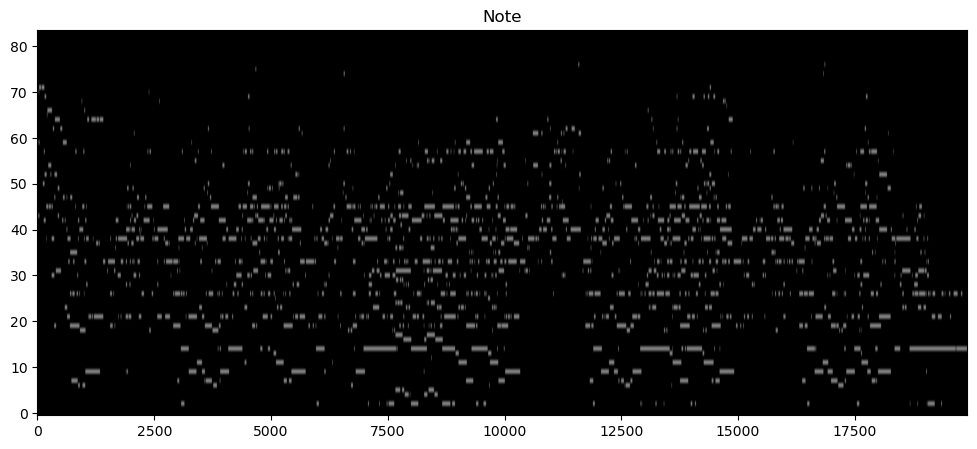

In [6]:
# 对于44100Hz的输入，可以用smallCQT自带的降采样函数
import torchaudio
from utils.midiarray import midi2numpy
from utils.wavtool import waveInfo
import matplotlib.pyplot as plt
import numpy as np
import os

# input_wav_path = "../data/inferMusic/孤独な巡礼simple.wav"
input_wav_path = "D:/Music/加藤達也-Always in my heart.mp3"

audio_name = os.path.basename(input_wav_path).split('.')[0]

try:    # 尝试加载同一目录下同名midi文件
    midi_path = os.path.join(os.path.dirname(input_wav_path), audio_name + '.mid')
    midi_array = midi2numpy(midi_path, s_per_frame)
except:
    midi_array = None

waveform, sample_rate = torchaudio.load(input_wav_path, normalize=True)
waveform = waveform.unsqueeze(0)

model.eval()
with torch.no_grad():
    # 降采样到22050Hz
    if sample_rate == 44100:
        waveform = model.cqt.down2sample(waveform)
        print("downsampled to 22050Hz")
    elif sample_rate != 22050:
        # 降采样
        wav_path = f"../test/{audio_name}_22050.wav"
        os.system(f'ffmpeg -i "{input_wav_path}" -vn -ar 22050 -y "{wav_path}"')
        print("saved downsampled wav to", wav_path)
        waveInfo(wav_path)
        waveform, sample_rate = torchaudio.load(wav_path, normalize=True)
        waveform = waveform.unsqueeze(0)

    onset, note = model(waveform)
    onset = onset.cpu().numpy()[0]
    note = note.cpu().numpy()[0]
    # 归一化
    note = note / np.max(note)
    onset = onset / np.max(onset)

if midi_array is None:
    plot_num = 2
    plt.figure(figsize=(12, plot_num * 5))
else:
    plot_num = 3
    plt.figure(figsize=(12, plot_num * 5))
    plt.subplot(plot_num, 1, 1)
    plt.title('Midi')
    plt.imshow(midi_array, aspect='auto', origin='lower', cmap='gray')

plt.subplot(plot_num, 1, plot_num - 1)
plt.title('Note')
plt.imshow(note, aspect='auto', origin='lower', cmap='gray')

plt.subplot(plot_num, 1, plot_num)
plt.title('Onset')
plt.imshow(onset, aspect='auto', origin='lower', cmap='gray')

plt.tight_layout()
plt.show()

# 二值化
mid = create_note("origin_"+audio_name, onset, note, s_per_frame)

In [ ]:
np.save("note.npy", note)
np.save("onset.npy", onset)
plt.imsave("note.png", note, origin='lower', cmap='gray')
plt.imsave("onset.png", onset, origin='lower', cmap='gray')

# 导出为接收44100Hz输入的ONNX模型
为了能在网页上使用，需要导出为onnx模型，接收44100Hz单通道音频输入。
需要额外安装以下内容：
```bash
pip install onnx
pip install onnxruntime
pip install onnxscript
```
注意onnxruntime有GPU版本，指令不一样。

In [2]:
import torch
import torch.nn as nn
from basicamt import BasicAMT_44100

model_44100 = BasicAMT_44100(model)

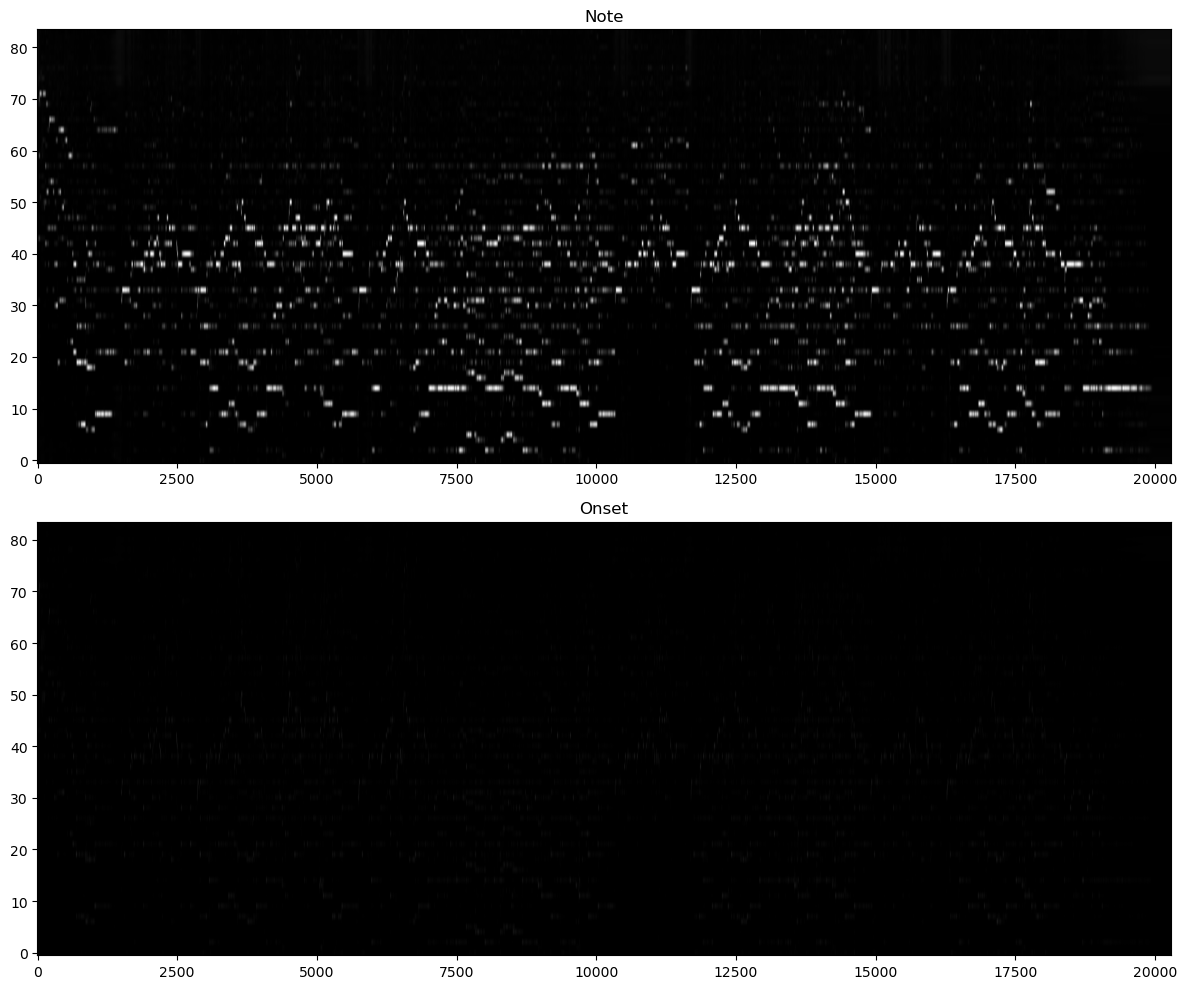

saved midi to '../test/new_加藤達也-Always in my heart.mid'


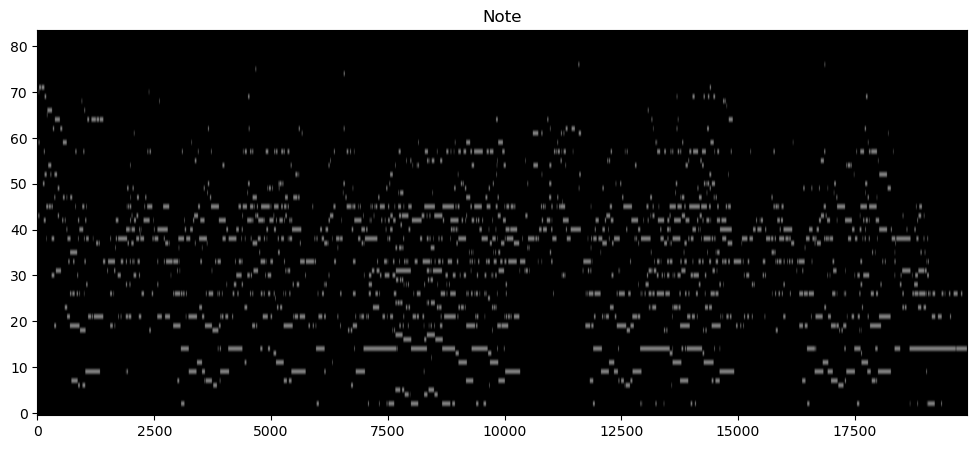

In [ ]:
# 测试新模型
import torchaudio
from utils.midiarray import midi2numpy
from utils.wavtool import waveInfo
import matplotlib.pyplot as plt
import numpy as np
import os

input_wav_path = "D:/Music/加藤達也-Always in my heart.mp3"

audio_name = os.path.basename(input_wav_path).split('.')[0]

try:    # 尝试加载同一目录下同名midi文件
    midi_path = os.path.join(os.path.dirname(input_wav_path), audio_name + '.mid')
    midi_array = midi2numpy(midi_path, s_per_frame)
except:
    midi_array = None

waveform, sample_rate = torchaudio.load(input_wav_path, normalize=True)
waveform = waveform.mean(-2, keepdim=True)
waveform = waveform.unsqueeze(0)

model_44100.eval()
with torch.no_grad():
    onset, note = model_44100(waveform)
    onset = onset.cpu().numpy()[0]
    note = note.cpu().numpy()[0]
    # 归一化（包含在模型内部）
    # note = note / np.max(note)
    # onset = onset / np.max(onset)

if midi_array is None:
    plot_num = 2
    plt.figure(figsize=(12, plot_num * 5))
else:
    plot_num = 3
    plt.figure(figsize=(12, plot_num * 5))
    plt.subplot(plot_num, 1, 1)
    plt.title('Midi')
    plt.imshow(midi_array, aspect='auto', origin='lower', cmap='gray')

plt.subplot(plot_num, 1, plot_num - 1)
plt.title('Note')
plt.imshow(note, aspect='auto', origin='lower', cmap='gray')

plt.subplot(plot_num, 1, plot_num)
plt.title('Onset')
plt.imshow(onset, aspect='auto', origin='lower', cmap='gray')

plt.tight_layout()
plt.show()

mid = create_note("new_"+audio_name, onset, note, s_per_frame)

In [3]:
# 导出为ONNX

model_44100.eval()

input_audio = torch.randn((1, 1, 22050), dtype=torch.float32)    # (fixed, fixed, dynamic)

with torch.no_grad():
    torch.onnx.export(
        model_44100,
        (input_audio,),
        'basicamt_44100.onnx',
        input_names = ["audio"],
        output_names = ["onset","frame"],
        dynamic_axes = {
            'audio': {2:'time'},
            'onset': {2:'frames'},
            'frame': {2:'frames'},
        },
        # dynamo=True,
        verbose=True,
        opset_version=20,
        verify=True
    )

d:\programs\timbreAMT\basicamt\..\model\CQT.py:65: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.size(1) > 1:   # only accept mono audio
d:\miniconda3\envs\amt\Lib\site-packages\torch\onnx\_internal\jit_utils.py:308: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\jit\passes\onnx\constant_fold.cpp:180.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
d:\miniconda3\envs\amt\Lib\site-packages\torch\onnx\utils.py:663: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at C:\cb\pytorch_100

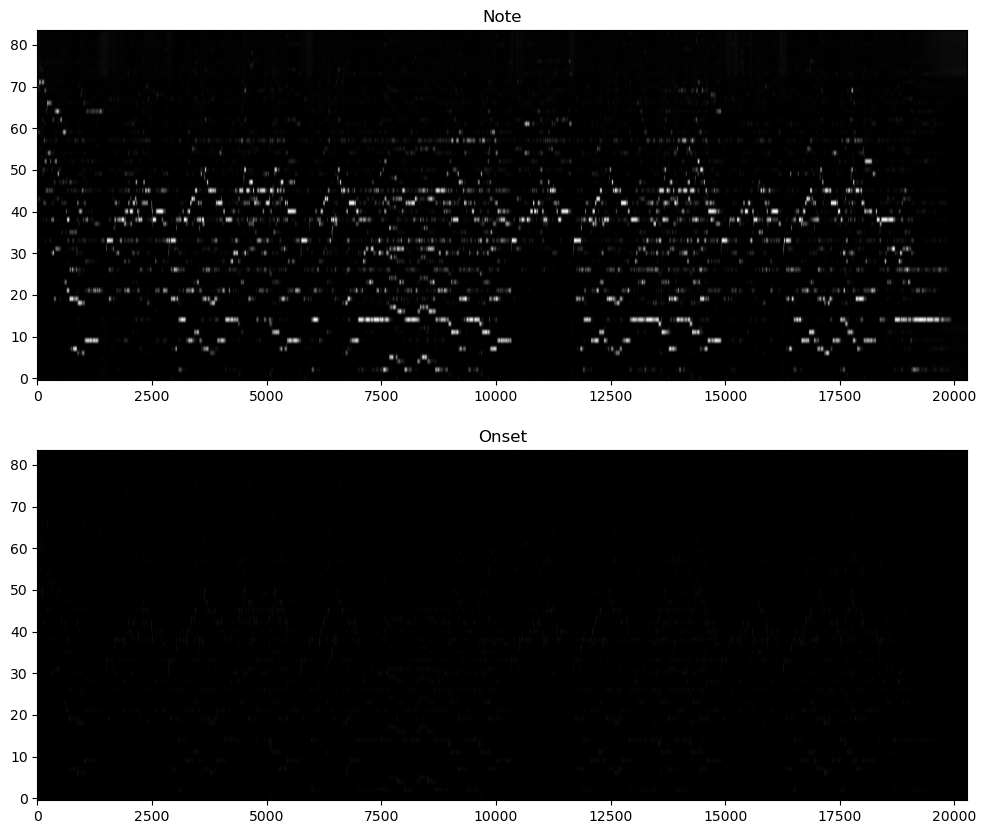

saved midi to '../test/onnx_加藤達也-Always in my heart.mid'


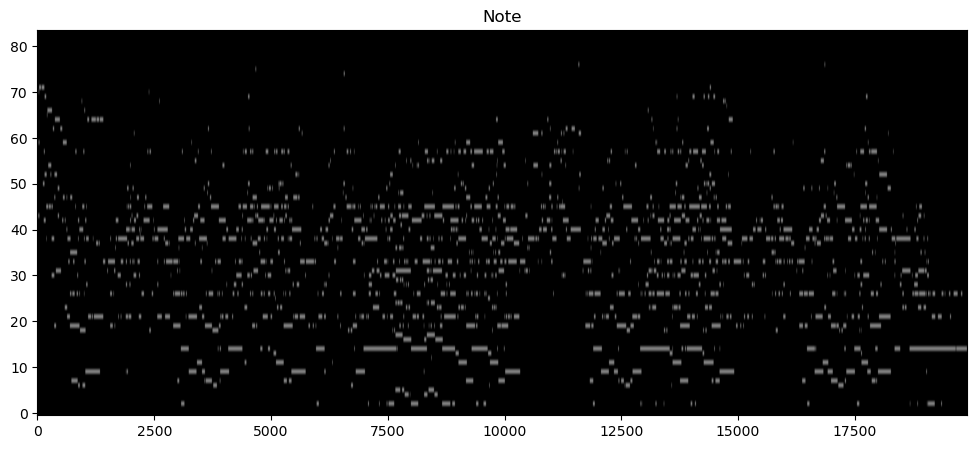

In [8]:
# 使用onnxruntime推理
import onnxruntime as ort
import numpy as np
import torchaudio
import os

ort_session = ort.InferenceSession("basicamt_44100.onnx") # 创建一个推理session

input_wav_path = "D:/Music/加藤達也-Always in my heart.mp3"
waveform, sample_rate = torchaudio.load(input_wav_path, normalize=True)
audio_name = os.path.basename(input_wav_path).split('.')[0]

waveform = waveform.unsqueeze(0).cpu()
if waveform.shape[1] > 1:
    waveform = waveform.mean(1, keepdim=True)
waveform = waveform.numpy().astype(np.float32)

outputs = ort_session.run(None, {'audio': waveform})
onset = outputs[0][0]
note = outputs[1][0]
# onset = onset / np.max(onset)
# note = note / np.max(note)

plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.title('Note')
plt.imshow(note, aspect='auto', origin='lower', cmap='gray')

plt.subplot(2, 1, 2)
plt.title('Onset')
plt.imshow(onset, aspect='auto', origin='lower', cmap='gray')

plt.show()

# 二值化
mid = create_note("onnx_"+audio_name, onset, note, s_per_frame)